In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load("training_input.npy", allow_pickle=True)
print("Background:")
background = data.item()['0']
print(background)
print("``````````````````")
print("Signal")
signal = data.item()['1']
print(signal)
test_data = np.load("test_input.npy",allow_pickle=True).item()
test_signal = test_data['1']
test_background = test_data['0']

Background:
[[-0.43079088  0.86834819 -0.92614721 -0.92662029 -0.56900862]
 [ 0.33924198  0.56155499  0.93097459 -0.91631726 -0.54463516]
 [-0.42888879  0.87064961 -0.92782179 -0.77533991 -0.58329176]
 [-0.43262871  0.86128919 -0.92240878 -0.88048862 -0.49963115]
 [-0.99925345 -0.99949586  0.07753685 -0.84218034 -0.5149399 ]
 [-0.99631106 -0.99775978  0.0756427  -0.54117216 -0.66299335]
 [-0.42645921  0.87141204 -0.92908723 -0.52650143 -0.62187526]
 [ 0.34317906  0.57125045  0.92638556 -0.85113425 -0.40170562]
 [-0.99904849 -0.99933931  0.07737929 -0.81161066 -0.53550246]
 [ 0.3371327   0.55874622  0.92996976 -0.9117092  -0.50996097]
 [ 0.89649306 -0.95523176 -0.66298651 -0.71276678 -0.62698893]
 [ 0.34293232  0.56408047  0.93448436 -0.88789589 -0.56154273]
 [-0.43055876  0.86615566 -0.92532229 -0.82531102 -0.61433506]
 [ 0.33970589  0.56676702  0.92567667 -0.91562035 -0.5946945 ]
 [-0.99924224 -0.99951208  0.07752116 -0.8360764  -0.56981171]
 [-0.43099755  0.86651251 -0.925269   -0.86

### NOTE

Keeping things simple and following instructions given about selecting one model, I've selected random forest and its variations to further improve the results. 

#### Random Forest
- Random forest
- Boosted trees
- Boosted with grid search

##### Random Forest
Let's look at how well the regular scikit-learn rf model handles the data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_

accuracy:  0.67
Recall Baseline: 1.0 Test: 0.68 Train: 1.0
Precision Baseline: 0.5 Test: 0.67 Train: 1.0
Roc Baseline: 0.5 Test: 0.75 Train: 1.0


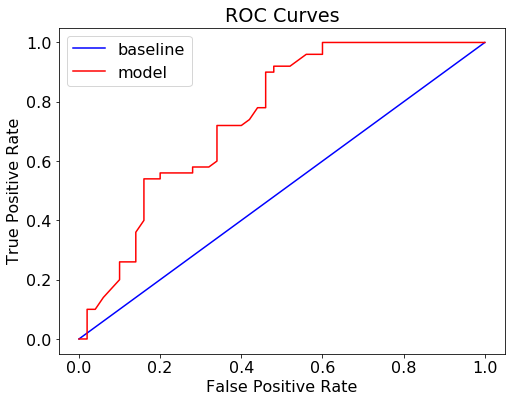

Confusion matrix, without normalization
[[33 17]
 [16 34]]


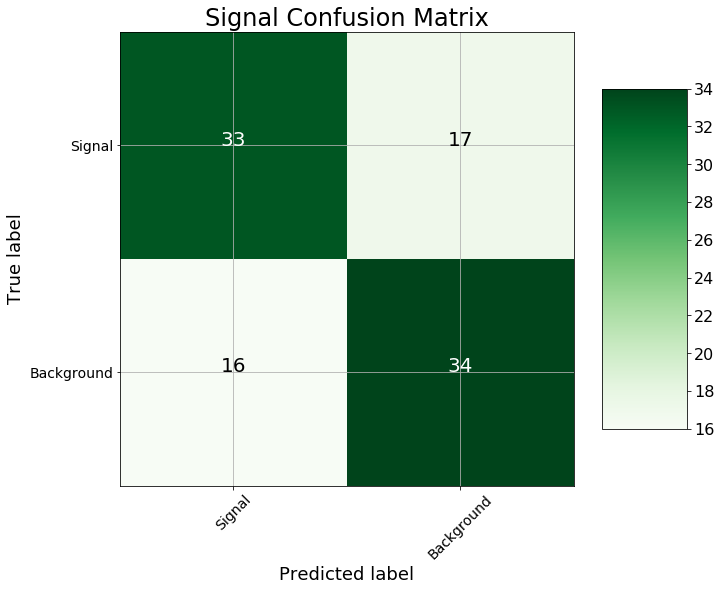

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

test_labels = np.zeros(100)
test_labels[50:100]=1

train_labels = np.zeros(100)
train_labels[50:100]=1

RSEED = 50
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
train = np.concatenate((background,signal), axis=0)
model.fit(train, train_labels)

test = np.concatenate((test_background, test_signal), axis=0)

train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

test_rf_predictions = model.predict(test)
test_rf_probs = model.predict_proba(test)[:, 1]

print("accuracy: ",accuracy_score(test_labels,test_rf_predictions))

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

def evaluate_model(predictions, probs, train_predictions, train_probs):
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(test_rf_predictions, test_rf_probs, train_rf_predictions, train_rf_probs)

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

cm = confusion_matrix(test_labels, test_rf_predictions)
plot_confusion_matrix(cm, classes = ['Signal', 'Background'],
                      title = 'Signal Confusion Matrix')

plt.show();

So the accuracy we get is 0.67, which isn't too great. Let's use a different variation.
##### Boosted Trees

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

test_labels = np.zeros(100)
test_labels[50:100]=1

train_labels = np.zeros(100)
train_labels[50:100]=1

train = np.concatenate((background,signal), axis=0)
test = np.concatenate((test_background,test_signal), axis=0)

classifier = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=90,
    learning_rate=0.01
)
classifier.fit(train, train_labels)
y_pred = classifier.predict(test)
print(accuracy_score(test_labels,y_pred))

0.72


So here we randomly selected parameters for `max_depth`, `n_estimators`, `learning_rate`. We improve performance by a bit 0.72 is better than 0.67. 
We can however obviously do better by fine tuning these parameters. 
Let's go through a few quick examples of randomly changing parameters.

In [5]:
classifier = GradientBoostingClassifier(
    max_depth=4,
    n_estimators=190,
    learning_rate=0.01
)
classifier.fit(train, train_labels)
y_pred = classifier.predict(test)
print("accuracy: ",accuracy_score(test_labels,y_pred))

accuracy:  0.66


In [6]:
classifier = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=190,
    learning_rate=0.001
)
classifier.fit(train, train_labels)
y_pred = classifier.predict(test)
print("accuracy: ",accuracy_score(test_labels,y_pred))

accuracy:  0.7


In [7]:
classifier = GradientBoostingClassifier(
    max_depth=4,
    n_estimators=1000,
    learning_rate=0.0001
)
classifier.fit(train, train_labels)
y_pred = classifier.predict(test)
print("accuracy: ",accuracy_score(test_labels,y_pred))

accuracy:  0.67


We can see that it can be quite varied. So how do we get the best parameters? Well here comes our next variation.
##### Boosted Trees with Grid Search

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

test_labels = np.zeros(100)
test_labels[50:100]=1

train_labels = np.zeros(100)
train_labels[50:100]=1

train = np.concatenate((background,signal), axis=0)
test = np.concatenate((test_background,test_signal), axis=0)

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,30,90]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)
clf.fit(train, train_labels)
print(clf.score(train, train_labels))
print(clf.best_params_)

result = clf.predict(test)

0.85
{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.3545454545454546, 'min_samples_split': 0.28181818181818186, 'n_estimators': 90, 'subsample': 0.8}


Now we can keep moving forward and could use xgboost as our library to explore and further improve results. However to keep the notebook relatively small, let's stop our exploration of Random Forests here.